In [4]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch import nn, optim

In [1]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [2]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

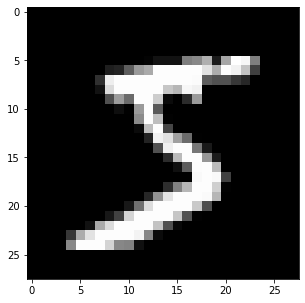

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Convolutional  Autoencoder

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='conv_enc_2.png' width=600px>


### Upsampling + Convolutions, Decoder

This decoder uses a combination of nearest-neighbor **upsampling and normal convolutional layers** to increase the width and height of the input layers.

It is important to note that transpose convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. This is the approach we take, here.

#### Summary of building the network shown above
>```
• Building the encoder out of a series of convolutional and pooling layers. 
• When building the decoder, we use a combination of upsampling and normal, convolutional layers.
```

In [5]:
model = nn.Sequential(nn.Conv2d(1, 16, 3, padding = 1),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.Conv2d(16, 4, 3, padding = 1),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.Upsample(scale_factor = 2, mode = 'nearest'),
                      nn.Conv2d(4, 16, 3, padding = 1),
                      nn.ReLU(),
                      nn.Upsample(scale_factor = 2, mode = 'nearest'),
                      nn.Conv2d(16, 1, 3, padding = 1),
                      nn.Sigmoid())

print(model)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Upsample(scale_factor=2.0, mode=nearest)
  (7): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): Upsample(scale_factor=2.0, mode=nearest)
  (10): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): Sigmoid()
)


---
## Training

Let us train the network. We are not interested in validation here, so we'll just monitor the training loss and the test loss.

We are not concerned with labels in this case, just images, which we can get from the train_loader. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, we'll use MSELoss. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

Otherwise, this is pretty straightfoward training with PyTorch. Since this is a convlutional autoencoder, our images do not need to be flattened before being passed in an input to our model.

In [6]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.303940
Epoch: 2 	Training Loss: 0.146243
Epoch: 3 	Training Loss: 0.131717
Epoch: 4 	Training Loss: 0.124875
Epoch: 5 	Training Loss: 0.120496
Epoch: 6 	Training Loss: 0.117456
Epoch: 7 	Training Loss: 0.114943
Epoch: 8 	Training Loss: 0.112907
Epoch: 9 	Training Loss: 0.111202
Epoch: 10 	Training Loss: 0.109579
Epoch: 11 	Training Loss: 0.107927
Epoch: 12 	Training Loss: 0.106427
Epoch: 13 	Training Loss: 0.104996
Epoch: 14 	Training Loss: 0.103660
Epoch: 15 	Training Loss: 0.102439
Epoch: 16 	Training Loss: 0.101389
Epoch: 17 	Training Loss: 0.100504
Epoch: 18 	Training Loss: 0.099733
Epoch: 19 	Training Loss: 0.099077
Epoch: 20 	Training Loss: 0.098489
Epoch: 21 	Training Loss: 0.097934
Epoch: 22 	Training Loss: 0.097365
Epoch: 23 	Training Loss: 0.096852
Epoch: 24 	Training Loss: 0.096407
Epoch: 25 	Training Loss: 0.096015
Epoch: 26 	Training Loss: 0.095271
Epoch: 27 	Training Loss: 0.094673
Epoch: 28 	Training Loss: 0.094227
Epoch: 29 	Training Loss: 0.0

## Checking out the results

Below let us plot some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

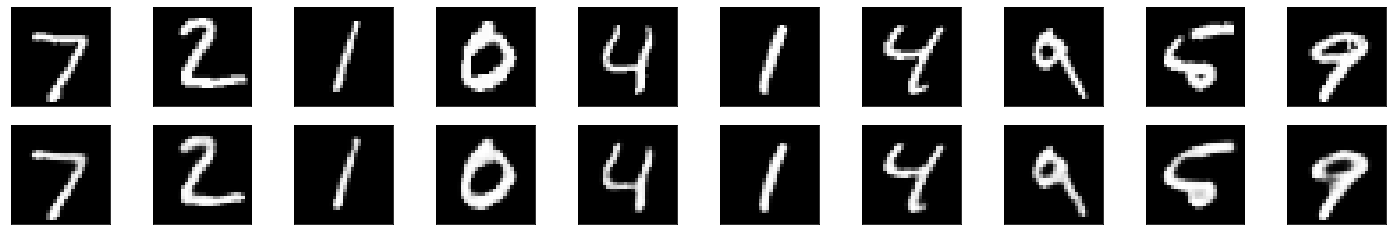

In [8]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)